# Query Translation in RAG

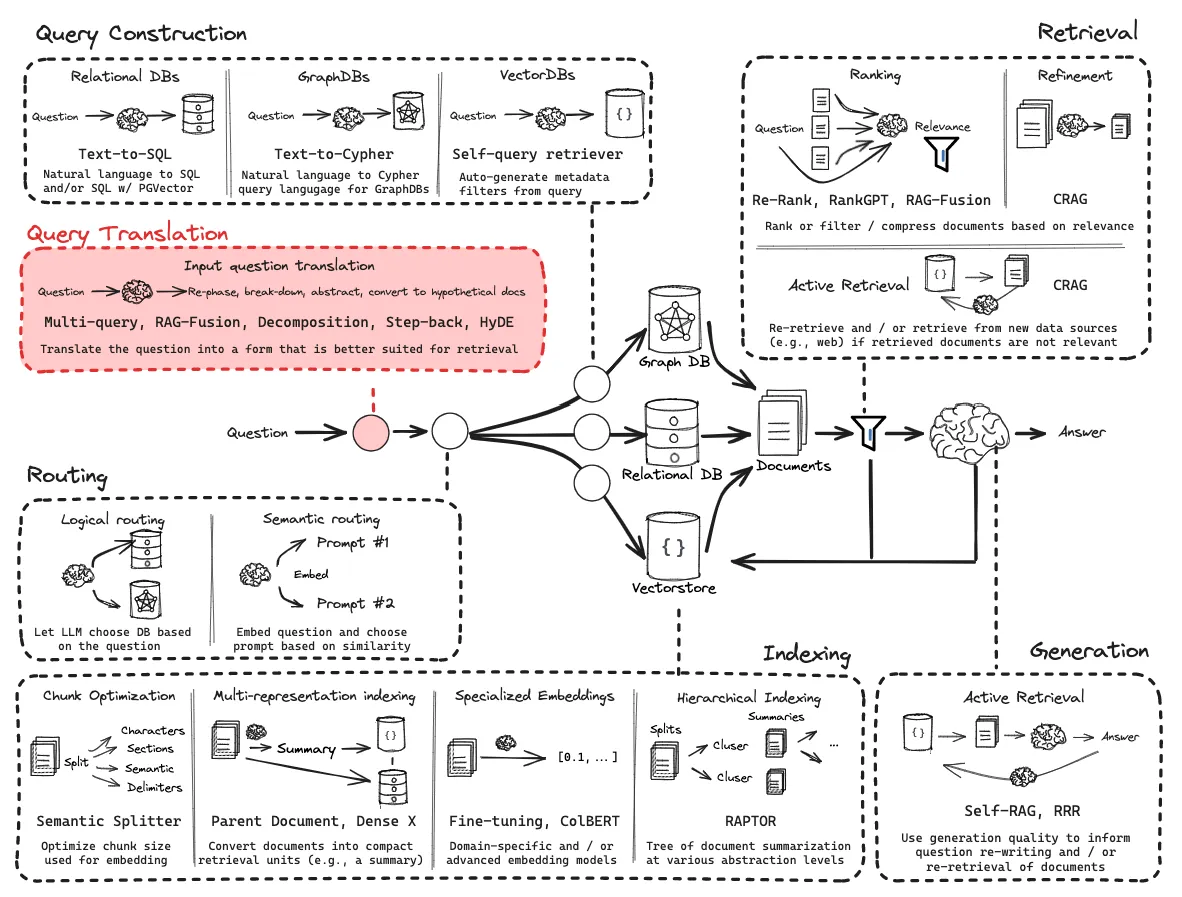

In [64]:
#Installing libraries 
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain
import os
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'

In [65]:
#QuickRAG

#Loading document
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(
    #adding the url to parse
    web_paths=(url,),
    #parsing variables
    bs_kwargs = dict(
        #The SoupStrainer class allows you to choose which parts of an incoming document are parsed
        parse_only=bs4.SoupStrainer(
            class_=("post-content","post-title","post-header")
        )
    ),
)

#Loading all documents in blogdocs variable
blogdocs = loader.load()

In [66]:
#Let's see what it looks like
print(blogdocs)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [67]:
#Splitting the documents 
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500,
    chunk_overlap = 50
)

doc_splits = splitter.split_documents(blogdocs)

In [68]:
#Indexing the documents 

embeddings = OllamaEmbeddings(
    model="all-minilm",
)

vectors = Chroma.from_documents(
    documents = doc_splits,
    embedding = embeddings
)

retriever = vectors.as_retriever()

## Multi- Query

The quality of extracted documents is directly related to the query the users inputs. So if the user inputs a horrible query - even if our RAG system is amazing - it won't reflect in the answers. 

So, with Multi-query - we'll use LLM to convert one query into multiple queries and retrieve documents for each query and take the union of the retrieved documents. 

In [69]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

#Writing prompt to generate 5 question out of the user input question
generating_5_perspectives = ChatPromptTemplate.from_template(
    """You're a helpful AI assistant. You're task is to generate 5 different versions of the 
    the question which will help the RAG system to retrieve relevant document. Make sure
    the questions have the same answers but all the questions should have different keywords
    to ensure semantic meaning of the answer is the same. 
    Your goal is to overcome limitations of distance based retrieval, irrelevant documents 
    retrieval. 
    Separate all questions by newlines
    Output only the questions - and nothing else.Don't give any introduction or any text at all, start your answer from the first question.  
    Original user query : {question}
    """
)

llm = ChatOllama(
    model="gemma3:1b",
    temperature=0
    )

queries = (
    generating_5_perspectives
    | llm 
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [70]:
#Let's test our code above. 

user_input = {
    "question" : "What benefits to using AI document processing tool for invoice & accounts payble?"
}

generated_queries = queries.invoke(user_input)

for i in range(len(generated_queries)):
    print(generated_queries[i])


What are the key advantages of employing AI-powered document processing tools for invoice and accounts payable management?

What are the primary benefits of using AI in automating invoice and accounts payable workflows?

How can AI document processing tools improve efficiency and accuracy in invoice and accounts payable processes?

What are the potential cost savings associated with integrating AI document processing into an accounting system?

What are the key features and functionalities that make AI document processing tools valuable for invoice and accounts payable tasks?


In [71]:
#Now let's write function that takes in a list of documents and outputs unique set of documents. 
from langchain.load import dumps, loads

   
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

In [72]:
#Let's see how we retrieve information now 

question = "Define task decomposition for LLM agents"

rag_chain_multiquery = queries | retriever.map() | get_unique_union 
docs = rag_chain_multiquery.invoke({"question" : question})
print(docs)


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\n[3] Liu et al. “Chain of Hindsight Aligns Language Models with Feedback\n“ arXiv preprint arXiv:2302.02676 (2023).\n[4] Liu et al. “LLM+P: Empowering Large Language Models with Optimal Planning Proficiency” arXiv preprint arXiv:2304.11477 (2023).\n[5] Yao et al. “ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.\n[6] Google Blog. “Announcing ScaNN: Efficient Vector Similarity 

In [73]:
#Quick RAG
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
prompt = hub.pull("rlm/rag-prompt")

#llm 
llm = ChatOllama(model='gemma3:1b', temperature=0)

#processing
def docs_format(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#ragchain 
rag_chain = (
    {"context": retriever | docs_format, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#que and ans 
ans = rag_chain.invoke("Define task decomposition for LLM agents")

print(ans)

The text describes different approaches to task decomposition for LLM agents, including Chain of Thought prompting, Tree of Thoughts reasoning, and the use of external planners like the Planning Domain Definition Language (PDDL). CoT and Tree of Thoughts are methods for breaking down complex tasks into smaller steps, while LLM+P leverages an external planner for long-horizon planning.


In [74]:
from operator import itemgetter
final_rag_multiquery = (
    {"context": rag_chain_multiquery,
       "question": itemgetter("question")}
     | prompt 
     | llm
     |StrOutputParser()   
)

ans_mq = final_rag_multiquery.invoke({"question":question})
print(ans_mq)

The context describes task decomposition as a process of breaking down complex tasks into smaller, manageable steps, utilizing prompting techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) to guide LLMs. It also highlights the role of external planning and reflection mechanisms in enhancing agent capabilities.


## RAG-Fusion
This approach is an enhanced multi-query approach with a ranker at the end of the multi-query layer that ranks the relevance of contexts and consumes them instead of a naive union like before

How RRF Works in RAG

Let’s break down the process of using RRF in a RAG system:

1. User Query: The process begins when a user inputs a question or query.

2. Multiple Retrievers: The query is sent to multiple retrievers. These could be different retrieval models (e.g., dense, sparse, hybrid). (We'll be using only one retriever here though) We will have multiple questions created from one question and then multiple retrievers will give us different documents.

3. Individual Rankings: Each retriever produces its own ranking of relevant documents. (We'll write function for this)

4. RRF Fusion: The rankings from all retrievers are combined using the RRF formula.

5. Final Ranking: A unified ranking is produced based on the RRF scores.

6. Generation: The generative model uses the top-ranked documents to produce the final answer.

In [79]:
def rrf_ragfusion (results: list[list], k=60):
    
    #creating a dict to store the scores for every document 
    scores = {}
    
    #getting all the lists from results
    for doclist in results: 
        #getting index and the document from the list
        for rank,doc in enumerate(doclist):
            
            # If the document is already in the score dictionary, update the score 
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            doc = doc_str
            if doc in scores:
                scoreold = scores.get("doc")
                scores['doc'] = scoreold + (1/(k+rank))
            #If document is not present, add the new entry wth the new rank score.     
            else:
                scores['doc'] = (1/(k+rank))
                
    #we need to sort the list in descending order. 
    sorted_scores = dict(sorted(scores.items(), key=lambda item:item[1], reverse=True))
    
    return sorted_scores

In [ ]:
#Let's run RAG with this RAG fusion method. 

rag_chain_ragfusion = (
    #here first we generate queries, give retrievers to map and find documents for every query and then instead
    #of naive fusion, we use rrf scoring. 
    {"context": queries | retriever.map() | rrf_ragfusion ,
       "question": itemgetter("question")}
     | prompt 
     | llm
     |StrOutputParser()   
)

ans = rag_chain_ragfusion.invoke({"question":question})
print(ans)

Task decomposition for LLM agents involves breaking down a complex goal into smaller, manageable subtasks. This allows the agent to focus on specific actions and improve efficiency. It’s a key technique for creating more robust and scalable AI systems.
